In [2]:
# !pip install torcheval
import pandas as pd
import numpy as np
from nfstream import NFStreamer, NFPlugin
from nfstream.flow import NFlow
import os
import seaborn as sns
import pandas as pd
from nfstream import NFStreamer, NFPlugin
from nfstream.flow import NFlow
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import copy
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
import intel_extension_for_pytorch as ipex
from sklearn.base import BaseEstimator,TransformerMixin
import matplotlib.pyplot as plt
import joblib
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libpng16.so.16: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
# device = torch.device("cpu")
print(device)
path = os.path.abspath("") + '/../datasets/' 
graph_path = path + '../graphs/'
# filename = 'capture-18-12-520k.pcapng'
# filename = 'plain-text-1.pcapng'
filename = 'encrypted2.pcapng'
# val_filename = 'communication-plain-mysql.pcapng'
val_filename_negative = 'unencrypted/dump'
val_filename_positive = 'encrypted/encr2'

# benign_path = path + 'dump'
torch.set_printoptions(sci_mode=False)
torch.autograd.set_detect_anomaly(True)

batch_size=24
ms_columns = [
    'bidirectional_duration_ms',
    'src2dst_duration_ms',
    'dst2src_duration_ms',
]
timestamps_columns = [
    'bidirectional_first_seen_ms',
    'bidirectional_last_seen_ms',
    'src2dst_first_seen_ms',
    'src2dst_last_seen_ms',
    'dst2src_first_seen_ms',
    'dst2src_last_seen_ms',
]
to_drop = [
    'bidirectional_first_seen_ms',
    'bidirectional_last_seen_ms',
    'src2dst_last_seen_ms',
    'dst2src_first_seen_ms',
    'dst2src_last_seen_ms',
    'src_ip', 'dst_ip', 
    'src_port', 'dst_port', 
    'protocol', 'src_oui', 
    'ip_version', 'dst_oui', 
    'application_name', 'application_category_name', 
    'vlan_id', 'expiration_id', 
    'content_type', 'client_fingerprint', 
    'server_fingerprint', 'user_agent', 
    'requested_server_name', 'src_mac', 
    'dst_mac', 'application_is_guessed', 
    'application_confidence', 'tunnel_id', 'id'
]
timestamp_col = 'src2dst_first_seen_ms'

xpu


## IpEncoder
Used to preprocess IP strings. Encodes 127.0.0.1 into 127 , 0, 0, 1. Used for __src_ip, dst_ip__ columns.
Output: DataFrame

In [57]:
streamer = NFStreamer(source=path + val_filename_positive, statistical_analysis=True)
df  = streamer.to_pandas()


In [1]:
# for l, val in df.groupby(timestamp_col):
#     print(len(val))

In [3]:
# Split IP into 4 features
class IpEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_tmp = X.copy()
        cols = X_tmp.columns.to_list()
        
        for column in self.column_names:
            new_names = [column + '_' + str(i) for i in range(4)]
            splitted = X_tmp[column].str.split('.', expand = True).astype(int)
            splitted.columns = new_names
            cols.append(new_names)
    
            X_tmp = pd.concat([X_tmp, splitted], axis = 1)
        X_tmp.drop(columns = self.column_names, inplace = True)
        return X_tmp


In [7]:
# Split IP into 4 features
class MsToSeconds(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_tmp = X.copy()
        cols = X_tmp.columns.to_list()
        
        for column in self.column_names:
            # new_names = [column + '_' + str(i) for i in range(4)]
            X_tmp[column] = (X_tmp[column]/1000).astype(float)
            # splitted.columns = new_names
            # cols.append(new_names)
    
            # X_tmp = pd.concat([X_tmp, splitted], axis = 1)
        # X_tmp.drop(columns = self.column_names, inplace = True)
        return X_tmp


In [7]:
# Split IP into 4 features
class TimestampsToLog(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_tmp = X.copy()
        cols = X_tmp.columns.to_list()
        
        for column in self.column_names:
            value = X_tmp[column]
            X_tmp[column] = X_tmp[column].apply(lambda x: 1 if x ==1 else (-1 if x ==0 else np.log(x).astype(float)))
            # print(value)
            # if value == 1:
            #     log_value = 1
            # elif value == 0:
            #     log_value = -1
            # else:
            #     log_value = np.log(X_tmp[column]).astype(float)
            # X_tmp[column] = log_value
        return X_tmp


In [8]:
# Split IP into 4 features
class DropExcessCols(BaseEstimator, TransformerMixin):
    def __init__(self, to_drop):
        self.to_drop = to_drop
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_tmp = X.copy()
        
        X_tmp = X_tmp.drop(columns=self.to_drop)
        # print(X_tmp.columns)
        return X_tmp


        # self.distro = np.array(self.distro)
        # self.distro = torch.tensor(self.distro).unsqueeze(1)

## Explore data

First, lets plot netflow clusters distribution

In [3]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# def plot_tsne(data, ax):
#     pca = PCA(n_components=50)
#     data_sampled = data.sample(2400) if len(data) > 2400 else data
#     X_reduced = pca.fit_transform(data_sampled)
#     tsne = TSNE(n_components=2)
#     X_modified = tsne.fit_transform(X_reduced)
#     df_modified = pd.DataFrame(X_modified)
#     sns.scatterplot(x = df_modified[0], y = df_modified[1], ax = ax)

# def preprocess(filename):
#     streamer = NFStreamer(source=path+filename, statistical_analysis=True)
#     ip_encoder = IpEncoder(['src_ip', 'dst_ip'])
#     df = streamer.to_pandas()
#     to
#     df = df[df['ip_version'] == 4].drop(columns = ['src_oui', 'ip_version', 'dst_oui', 'application_name', 'application_category_name', 'vlan_id', 'expiration_id', 'content_type', 'client_fingerprint', 'server_fingerprint', 'user_agent', 'requested_server_name', 'src_mac', 'dst_mac', 'application_is_guessed', 'application_confidence', 'tunnel_id', 'id'])
#     X_transformed = ip_encoder.fit_transform(df)
#     return X_transformed



# fig, ax =plt.subplots(1,2)
# plot_tsne(preprocess(filename), ax=ax[0])
# plot_tsne(preprocess(val_filename), ax=ax[1])
# fig.show()

Now we will plot a heatmap of payload bytes distribution

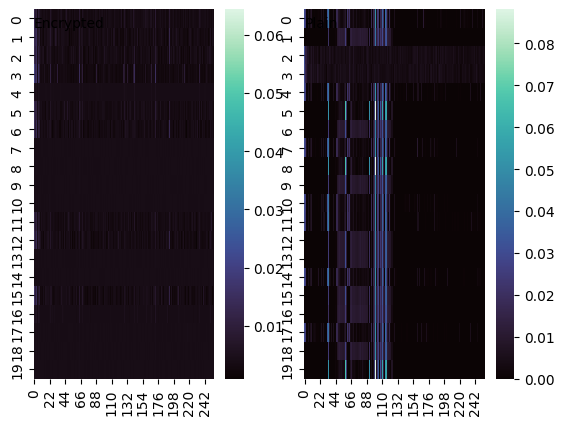

In [334]:
def get_distro(filename):
    streamer = NFStreamer(source=path+filename, udps=PayloadCollector())
    distro = []
    for flow in streamer:
        distro.append(flow.udps.payload_byte_distro)
    return np.array(distro)
def plot_distro(distro, ax):
    sns.heatmap(distro[100:120], cmap="mako", cbar=True, ax = ax)
encr_flows_distro = get_distro(filename)
plain_flows_distro = get_distro(val_filename)
fig, ax = plt.subplots(1,2)
ax[0].annotate('Encrypted', xy=(0, 1))
ax[1].annotate('Plain', xy=(0,1))

plot_distro(encr_flows_distro, ax=ax[0])
plot_distro(plain_flows_distro, ax=ax[1])
fig.show()

## NFPlugin to extract payload bytes distribution

In [6]:
import collections
bytes_distro = []
class PayloadCollector(NFPlugin):

    @staticmethod
    def _extend_flow_payload(packet, flow):
        if packet.payload_size > 0:
            payload = packet.ip_packet
            byte_counter = collections.Counter(payload)
            flow.udps.payload_byte_distro += [byte_counter.get(byte, 0) for byte in range(256)]

    def on_init(self, packet, flow):
        flow.udps.payload_byte_distro = np.zeros(256)
        self._extend_flow_payload(packet, flow)

    def on_update(self, packet, flow):
        self._extend_flow_payload(packet, flow)
    def on_expire(self, flow):
        flow.udps.payload_byte_distro = flow.udps.payload_byte_distro/max(1, sum(flow.udps.payload_byte_distro))

## Metadata dataset class
Creates network flows and fits them into a pipeline to process. 
Output: tensor of shape __N of flows, 1, 74__

In [66]:
class FlowDataset(Dataset):
  def __init__(self, flows, transforms = None):
    print(flows)
    self.flows = flows
    ts = self.flows.groupby(timestamp_col)
    self.data = []
    for ts_value, ts_flows in ts:
        tensor = torch.tensor(ts_flows.drop(columns=[timestamp_col]).values, dtype=torch.float32)
        self.data.append(tensor)
    self.transform = transforms
    # self.data = torch.tensor(self.data)

  def __getitem__(self, idx):
      sample = self.data[idx]
      if self.transform:
            sample = self.transform(sample)
      return sample

  def __len__(self):
    return len(self.flows)


In [81]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Separate sequences and targets
    sequences, targets = zip(*batch)
    
    # Convert sequences to tensors and pad them to the same length
    sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    
    # Convert targets to tensor
    targets = torch.tensor(targets, dtype=torch.float32)
    
    # Sequence lengths (before padding)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.int64)
    
    return padded_sequences, targets, lengths


## Payload dataset class
Using PayloadCollector plugin, payload bytes distribution is extracted for each flow and converted to a dataframe
Output: tensor of shape __N of flows, 1, 256__

In [49]:
# class PayloadDataset(Dataset):
#   def __init__(self, filename, transform = None):
#     self.streamer = NFStreamer(source = filename, udps = PayloadCollector())
#     self.distro = []
#     for flow in self.streamer:
#         if flow.ip_version == 4:
#             self.distro.append(flow.udps.payload_byte_distro)
#     self.distro = np.array(self.distro)
#     self.distro = torch.tensor(self.distro).unsqueeze(1)
#     self.transform = transform

#   def __getitem__(self, idx):
      
#     sample = self.distro[idx]
#     if self.transform:
#         sample = self.transform(sample.unsqueeze(1))[0]
#     return sample

#   def __len__(self):
#     return len(self.distro)


In [5]:
class AppendPayloadDistro(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_temp = X.copy()
    
        columns = ['byte_' + str(i) for i in range(256)]
        distro = []
        distros = X_temp['udps.payload_byte_distro']
        
        for d in distros:
            values = d.strip('[]').split()
            distro.append(list(map(float, values)))
    
        X_temp = X_temp.drop(columns = ['udps.payload_byte_distro'])

        distro_df = pd.DataFrame(distro, columns = columns)
        # print(distro_df.head())
        # print(f'X_temp: {X_temp.shape}, distro: {distro_df.shape}')
        # # X_temp = 
        
        return pd.concat([X_temp.reset_index(drop=True), distro_df], axis=1)

## Assigning datasets

__flow_df__ - flow-based properties - 63 features
__packet_df__ - packet-based payload bytes distribution - 256 features

In [67]:
columns = [
       'bidirectional_duration_ms', 'bidirectional_packets',
       'bidirectional_bytes', 'src2dst_first_seen_ms',
       'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes',
        'dst2src_duration_ms',
       'dst2src_packets', 'dst2src_bytes', 'bidirectional_min_ps',
       'bidirectional_mean_ps', 'bidirectional_stddev_ps',
       'bidirectional_max_ps', 'src2dst_min_ps', 'src2dst_mean_ps',
       'src2dst_stddev_ps', 'src2dst_max_ps', 'dst2src_min_ps',
       'dst2src_mean_ps', 'dst2src_stddev_ps', 'dst2src_max_ps',
       'bidirectional_min_piat_ms', 'bidirectional_mean_piat_ms',
       'bidirectional_stddev_piat_ms', 'bidirectional_max_piat_ms',
       'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms',
       'src2dst_max_piat_ms', 'dst2src_min_piat_ms', 'dst2src_mean_piat_ms',
       'dst2src_stddev_piat_ms', 'dst2src_max_piat_ms',
       'bidirectional_syn_packets', 'bidirectional_cwr_packets',
       'bidirectional_ece_packets', 'bidirectional_urg_packets',
       'bidirectional_ack_packets', 'bidirectional_psh_packets',
       'bidirectional_rst_packets', 'bidirectional_fin_packets',
       'src2dst_syn_packets', 'src2dst_cwr_packets', 'src2dst_ece_packets',
       'src2dst_urg_packets', 'src2dst_ack_packets', 'src2dst_psh_packets',
       'src2dst_rst_packets', 'src2dst_fin_packets', 'dst2src_syn_packets',
       'dst2src_cwr_packets', 'dst2src_ece_packets', 'dst2src_urg_packets',
       'dst2src_ack_packets', 'dst2src_psh_packets', 'dst2src_rst_packets',
       'dst2src_fin_packets']
ct = ColumnTransformer([
    ('scaler', MinMaxScaler(), columns)
], remainder='passthrough')

pipeline = Pipeline(steps= [
        ('dropper', DropExcessCols(to_drop)),
        ('mstosec', MsToSeconds(ms_columns)),
        # ('tstolog', TimestampsToLog(timestamps_columns)),
        
        ('distro', AppendPayloadDistro()),
        # ('scaler', ct),
    ])
flow_df = FlowDataset(preprocess(path + filename, pipeline, True))
# flow_df
flow_val_df_negative = FlowDataset(preprocess(path + val_filename_negative, pipeline))
flow_val_df_positive = FlowDataset(preprocess(path + val_filename_positive, pipeline))

flow_input_dim = flow_df[0].shape[1]


print(f'Total samples train: {len(flow_df)}')
print(f'Total samples val_positive: {len(flow_val_df_positive)}')
print(f'Total samples val_negative: {len(flow_val_df_negative)}')
print(f'Flow input dim: {flow_input_dim}')


/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      bidirectional_duration_ms  bidirectional_packets  bidirectional_bytes  \
0                         0.066                     35                11013   
1                         0.092                     41               124327   
2                         4.784                    271               209156   
3                         0.649                    273               287460   
4                         4.656                    407               280837   
...                         ...                    ...                  ...   
6504                      0.068                    123               717571   
6505                      0.114                     18                 5181   
6506                      0.268                    357              2774317   
6507                      0.222                    122               717505   
6508                      0.051                    118               717360   

      src2dst_first_seen_ms  src2dst_duration_ms  s

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


      bidirectional_duration_ms  bidirectional_packets  bidirectional_bytes  \
0                         0.253                     40                14300   
1                         4.054                     62                20827   
2                         3.965                     87                27119   
3                         8.103                     48                28507   
4                         0.190                    172                99603   
...                         ...                    ...                  ...   
1038                      0.194                    265              1200100   
1039                      0.764                     21                 5505   
1040                      0.175                     33                10734   
1041                      0.120                    354              2728803   
1042                      0.103                    272              1210416   

      src2dst_first_seen_ms  src2dst_duration_ms  s

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [82]:
# for d in flow_df.data:
#     print(d.shape)

In [58]:
joblib.dump(pipeline, 'ae_pipeline.gz')

['ae_pipeline.gz']

## Mean and std calculation

In [80]:
flow_loader

In [83]:
flow_loader = DataLoader(flow_df, batch_size=1000, collate_fn=collate_fn)
# packet_loader = DataLoader(packet_df, batch_size=1000)
def get_mean_std(loader, n_features, df):
    num_samples = 0
    for d in df:
        num_samples += d.shape[0]
    total_length = num_samples * n_features
    total_sum = 0
    for batch in loader: 
        total_sum += batch.sum()
    mean = total_sum/total_length
    sse = 0 # sum of squared error
    for batch in loader:
        sse += ((batch - mean).pow(2)).sum()
    std = torch.sqrt(sse/total_length)
    return mean, std

flow_mean, flow_std = get_mean_std(flow_loader, flow_input_dim, flow_df)
# packet_mean, packet_std = get_mean_std(packet_loader, packet_input_dim, packet_df)
print(f'Flow mean: {flow_mean}, std: {flow_std}')
# print(f'Packet mean: {packet_mean}, std: {packet_std}')
flow_tr = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(flow_mean, flow_std)
])
flow_df.transform = flow_tr
flow_val_df_positive.transform = flow_tr
flow_val_df_negative.transform = flow_tr


ValueError: not enough values to unpack (expected 2, got 1)

In [10]:
class FlowNormalizer:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        self.normalizer = torchvision.transforms.Normalize(mean=self.mean, std=self.std)

    def normalize(self, tensor_input):
        return self.normalizer(tensor_input)
    
    def get_mean_std(self):
        return self.mean, self.std



In [ ]:
normalizer = FlowNormalizer(flow_mean, flow_std)
torch.save(normalizer, 'ae_normalizer.pth')

## Check validation set mean and std
As we apply the same normalization to train and real data, let's check how far from normal (mean = 0 and std = 1) are validation values

In [28]:
loader = DataLoader(flow_val_df_positive, batch_size = len(flow_df))
data = next(iter(loader))
for d in data.permute(1, 0, 2)[0]:
    # print(d[11])
    if d.sum() == -np.inf:
        print(d)
data.permute(1, 0, 2)[0].mean(), data.permute(1, 0, 2)[0].std()

(tensor(-0.0075, dtype=torch.float64), tensor(0.9627, dtype=torch.float64))

## Define loaders

In [29]:
flow_train_loader = DataLoader(flow_df, batch_size=batch_size)
flow_val_loader_positive = DataLoader(flow_val_df_positive, batch_size=batch_size)
flow_val_loader_negative = DataLoader(flow_val_df_negative, batch_size=batch_size)

print(f'Total batches train: {len(flow_train_loader)}')
print(f'Total batches val positive: {len(flow_val_loader_positive)}')
print(f'Total batches val negative: {len(flow_val_loader_negative)}')
print(f'Flow train loader batch shape: {next(iter(flow_train_loader)).shape}')
# print(f'Packet train loader batch shape: {next(iter(packet_train_loader)).shape}')

Total batches train: 272
Total batches val positive: 44
Total batches val negative: 9
Flow train loader batch shape: torch.Size([24, 1, 313])


## LSTM based autoencoder
The Autoencoder has 2 LSTM layers and 2 Linear layers dividing them

In [12]:
class Encoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout = 0, device = 'cpu'):
        super(Encoder, self).__init__()
        self.device = device
        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # print("Encoder device: " + str(device))
        self.lstm = nn.LSTM(input_size = nb_feature, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = dropout, bias = True).to(device)

    def initHidden(self, batch_size):
        self.hidden_cell = (
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device),
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device)
        )
    def forward(self, input_seq):
        self.initHidden(input_seq.shape[0])
        _, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        return self.hidden_cell
        
class Decoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(Decoder, self).__init__()

        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        # print("Decoder device: " + str(device))
        self.lstm = nn.LSTM(input_size=nb_feature, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bias=True).to(device)
        self.linear = nn.Linear(in_features=hidden_size, out_features=nb_feature).to(device)

    def forward(self, input_seq, hidden_cell):
        output, hidden_cell = self.lstm(input_seq, hidden_cell)
        output = self.linear(output)
        return output, hidden_cell
        
class LSTMAutoEncoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(LSTMAutoEncoder, self).__init__()
        self.device = device
        self.encoder = Encoder(num_layers, hidden_size, nb_feature, dropout, device).to(device)
        self.decoder = Decoder(num_layers, hidden_size, nb_feature, dropout, device).to(device)
        # print("Main device: " + str(device))

    def forward(self, input_seq):
        output = torch.zeros(size=input_seq.shape, dtype=torch.float).to(self.device)
        hidden_cell = self.encoder(input_seq)
        input_decoder = input_seq[:, -1, :].view(input_seq.shape[0], 1, input_seq.shape[2])
        for i in range(input_seq.shape[1] - 1, -1, -1):
            output_decoder, hidden_cell = self.decoder(input_decoder, hidden_cell)
            input_decoder = output_decoder
            output[:, i, :] = output_decoder[:, 0, :]
        return output

## Custom R2 function

In [40]:
def r2_score(y_true, y_pred):
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

    y_mean = torch.mean(y_true)

    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - y_mean) ** 2)
    
    # Calculate R^2
    r2 = 1 - ss_res / (ss_tot + 1e-8)  # Add epsilon to avoid division by zero
    
    return r2.item()  # Return as a Python float


## Training loop
- Loss should go down
- R2 should go up
- validation_loss_positive should go down (model performance on "unseen" encrypted flows)
- validation_loss_negative should stay high as we validate on unencrypted payload

In [37]:
epochs = 50
learning_rate = 1e-4

# criterion = nn.SmoothL1Loss(reduction='sum').to(device)
criterion = nn.MSELoss().to(device)
# metric = R2Score().to(device)

def train_one_epoch(model, loader, optimizer, val = False):
    running_loss = 0.
    r2 = []
    for i, batch in enumerate(loader):
        inputs = batch.float().permute(1, 0, 2).to(device)
        if not val: 
            optimizer.zero_grad() 
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        if not val:
            loss.backward() 
            optimizer.step()
        running_loss += loss.item()
        
        r2.append(r2_score(inputs, outputs))
    running_loss = running_loss / len(loader)
    r2 = np.array(r2)
    return running_loss, np.mean(r2)

def training_loop(model, train_loader, val_loader_positive, val_loader_negative, history, epochs = 50):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print('Epoch | train_loss | val_loss_positive | val_loss_negative | R2 train | R2 val')
    for epoch in range(epochs):
        model.train()
        training_loss, r2_train = train_one_epoch(model, train_loader, optimizer)
        model.eval() 
        val_loss = []
        with torch.no_grad(): 
            val_loss_negative, _ = train_one_epoch(model, val_loader_negative, optimizer, val = True)
            val_loss_positive, r2_val = train_one_epoch(model, val_loader_positive, optimizer, val = True)
        history.append({'loss': training_loss, 'r2_train': r2_train, 'r2_val': r2_val, 'val_loss_negavtive': val_loss_negative, 'val_loss_positive': val_loss_positive})
        print(f'{epoch + 1} | {training_loss} | {val_loss_positive} | {val_loss_negative} | {r2_train} | {r2_val}')
    return history

## Train autoencoder

In [83]:
flow_ae = LSTMAutoEncoder(num_layers = 1, hidden_size = 40, nb_feature = flow_input_dim, device = device).to(device)

In [85]:
print("Training Flow AE:")
try:
    flow_history = np.load('ae_train.npy')
except:
    flow_history = []
# flow_history = np.open('history')
training_loop(flow_ae,
              train_loader = flow_train_loader, 
              val_loader_positive = flow_val_loader_positive,
              val_loader_negative = flow_val_loader_negative,
              history = flow_history, 
              epochs = 90
             )

Training Flow AE:
Epoch | train_loss | val_loss_positive | val_loss_negative | R2 train | R2 val
1 | 0.7762559274321094 | 0.48766943405974994 | 2.395216918653912 | 0.21267342655097737 | 0.4735474911603061
2 | 0.45596017425551133 | 0.33763155476613477 | 2.1266500453154245 | 0.5415682089241112 | 0.6323569281534716
3 | 0.3530484774862142 | 0.27020581608468835 | 2.009632867243555 | 0.6441087341483902 | 0.7029141201214357
4 | 0.3001413056079079 | 0.23103908788074146 | 1.9350485536787245 | 0.6960749179124832 | 0.7437484210187738
5 | 0.268238477573237 | 0.20641762323000215 | 1.9086110873354807 | 0.7274191009209436 | 0.769433781504631
6 | 0.24735735827947364 | 0.19042339311404663 | 1.8845546063449647 | 0.748203381896019 | 0.786133661866188
7 | 0.23260011737618377 | 0.17842457629740238 | 1.8720063583718405 | 0.763152539730072 | 0.79935084418817
8 | 0.2219865391140475 | 0.1688224102624438 | 1.8643665214379628 | 0.7741343769080499 | 0.8106398392807354
9 | 0.21397490665207014 | 0.16093676113946873

KeyboardInterrupt: 

In [86]:
with open('ae_train.npy', 'wb') as f:
    np.save(f, flow_history)
    # np.save(f, np.array([1, 3]))

In [250]:
history_df = pd.DataFrame(flow_history)
history_df.to_csv('flow_history.csv', sep='\t')

## Plotting loss 
After trying training on small subsets, we will now see how loss was changing and tweak model parameters

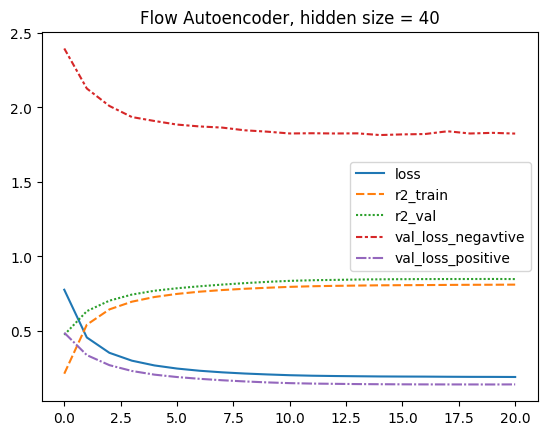

In [99]:
flow_history = np.load('ae_train.npy', allow_pickle=True)
# list(flow_history)
stats = pd.DataFrame(list(flow_history))
# stats
sns.lineplot(stats).set_title("Flow Autoencoder, hidden size = 40")
plt.savefig('flow_ae_final.png')

In [68]:
# flow_ae.pth packet_ae, packet_ae1
torch.save(model, path + 'flow_final_ae.pth')

tensor(0.4926, device='xpu:0')


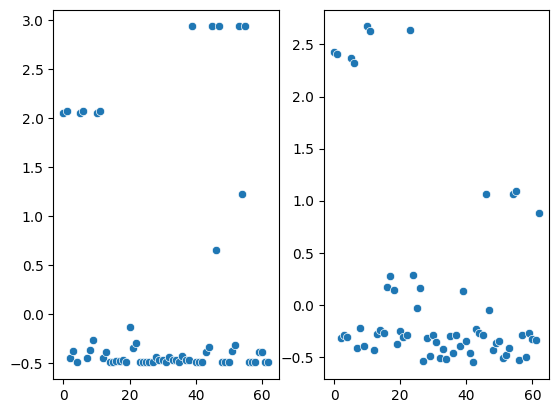

In [302]:
values = next(iter(flow_val_loader_negative)).float().permute(1, 0, 2).to(device)
i = 20
pred = packet_model(values).detach()[0][i]
# print(values[0][0])
# print(pred[0][0])
fig, ax = plt.subplots(1,2)
sns.scatterplot(values[0][i].cpu(), ax = ax[0])
sns.scatterplot(pred.cpu(), ax = ax[1])

fig.show()
# print(values[0][i])
print((values[0][i] - pred).sum())

In [23]:
attacks = {
    'BENIGN': 1,
    'SQL_INJ': 5,
    'XSS': 6,
    'DDOS': 7,
    'PORTSCAN': 8
}

## Create dataset for attacks classifier

In [13]:
pipeline = joblib.load('models/ae_pipeline.gz')
# pipeline
normalizer = torch.load('models/ae_normalizer.pth')
model = torch.load('models/flow_final_ae.pth')

In [44]:
benign_path = path + 'classification/benign.pcap'
sql_inj_path = path + 'classification/sql-injection.pcap'
xss_path = path + 'classification/xss.pcapng'
ddos_path = path + 'classification/ddos'
# plain_redis_path = path + 'classification/plain-redis.pcap'
portscan_path = path + 'classification/portscan/part'
# redis_warning_response = 'classification/warning_redis_response.pcapng'
# plain_sql_path = path + 'classification/plain_mysql.pcap'
# plain_pass_path = path + 'classification/secure-data-http.pcapng'
def preprocess(filename, pipeline, fit=False):
    streamer = NFStreamer(source = filename, statistical_analysis=True, udps = PayloadCollector())
    flows = streamer.to_pandas()
    flows = flows[flows['ip_version'] == 4]
    if fit: pipeline = pipeline.fit(flows)
    
    return pipeline.transform(flows)
    
def prepare_input(filename, pipeline, normalizer):
    data = preprocess(filename, pipeline)
    data_tensors = torch.tensor(np.array(data)).unsqueeze(1)
    columns = [f.replace('scaler__', '').replace('remainder__', '') for f in pipeline['scaler'].get_feature_names_out()]
    return normalizer.normalize(data_tensors), columns
    
def to_pandas(dataset, label, columns):
    data = [] 
    # columns = list(columns)
    columns.append('label')
    for flow in dataset:
        new_flow = flow.view(-1).numpy()
        data.append([*new_flow, label])
    return pd.DataFrame(data, columns = columns)
    
def get_df(filename, label, pipeline, normalizer):
    packets, columns = prepare_input(filename, pipeline, normalizer)
    packets = packets.float().to(device)
    predictions = model(packets).detach()
    rows = np.abs(packets.cpu() - predictions.cpu())
    return to_pandas(rows, label, columns)

def divide_df(df, train_size = 0.8, shuffle = False):
    X_train, X_test = train_test_split(df, train_size = train_size, shuffle = shuffle)
    X_test, X_val = train_test_split(X_test, train_size = 0.8, shuffle = shuffle)
    return X_train, X_test, X_val

def create_datasets(filemap):
    train = []
    test = []
    val = []
    for label, filename in filemap:
        print(filename)
        df = get_df(filename, label, pipeline, normalizer)
        train_tmp, test_tmp, val_tmp = divide_df(df)
        train.append(train_tmp)
        test.append(test_tmp)
        val.append(val_tmp)
    return pd.concat(train, axis = 0), pd.concat(test, axis = 0), pd.concat(val, axis = 0)

filemap = [
    (attacks['BENIGN'], benign_path),
    (attacks['SQL_INJ'], sql_inj_path),
    (attacks['XSS'], xss_path),
    (attacks['DDOS'], ddos_path),
    # (attacks['PLAIN_REDIS'], plain_redis_path),
    # (attacks['PLAIN_SQL'], plain_sql_path),
    # (attacks['PLAIN_PASS'], plain_pass_path),
    (attacks['PORTSCAN'], portscan_path)
]

train, test, val = create_datasets(filemap)        

/jupyter/shared/../datasets/classification/benign.pcap
/jupyter/shared/../datasets/classification/sql-injection.pcap
/jupyter/shared/../datasets/classification/xss.pcapng
/jupyter/shared/../datasets/classification/ddos
/jupyter/shared/../datasets/classification/portscan/part


## Save into CSV

In [45]:
train['label'].value_counts()

label
8    10000
6     2069
7     1106
1      676
5      249
Name: count, dtype: int64

In [47]:
train.reset_index(drop=True).to_csv(path + 'attacks_train.csv', index=False)
# train_y.reset_index(drop=True).to_csv(path + 'attacks_train_y.csv', index=False)
test.reset_index(drop=True).to_csv(path + 'attacks_test.csv', index=False)
val.reset_index(drop=True).to_csv(path + 'attacks_val.csv', index=False)
# test_y.reset_index(drop=True).to_csv(path + 'attacks_test_y.csv', index=False)

## Load and set dimensions

In [28]:
class AttackDataset(Dataset):
  def __init__(self, filename, transforms = None):
    self.df = pd.read_csv(filename)
    self.transform = transforms

  def __getitem__(self, idx):
      sample = self.df.iloc[idx, :-1]
      label = self.df.iloc[idx, -1:]
      return torch.tensor(sample.to_numpy()), torch.tensor(label.to_numpy())

  def __len__(self):
    return self.df.shape[0]


In [51]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
attack_train = AttackDataset(path + 'attacks_train.csv', transforms = transforms)
# train_y = AttackDataset(path + 'attacks_train_y.csv', transforms = transforms)
attack_test = AttackDataset(path + 'attacks_test.csv', transforms = transforms)
attack_val = AttackDataset(path + 'attacks_val.csv', transforms = transforms)
# test_y = AttackDataset(path + 'attacks_test_y.csv', transforms = transforms)
attack_input_dim = attack_train[0][0].shape[0]
attack_output_dim = 1
print(f'Input dim: {attack_input_dim}, output dim: {attack_output_dim}')

Input dim: 313, output dim: 1


In [30]:
attack_train_loader = DataLoader(attack_train, batch_size=64)
attack_val_loader = DataLoader(attack_val, batch_size=64)

## Create classifier

In [315]:
class AttackClassifier(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(AttackClassifier, self).__init__()
        self.layer1 = nn.Linear(in_dim, 10)
        self.relu = nn.ReLU()
        # self.layer2 = nn.Linear(120, 10)
        self.layer2 = nn.Linear(10, out_dim)
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x
        return x

In [345]:
attack_classifier = AttackClassifier(attack_input_dim, attack_output_dim).to(device)

## Training classifier

In [343]:
epochs = 50
learning_rate = 1e-4

# criterion = nn.SmoothL1Loss(reduction='sum').to(device)
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# metric = R2Score().to(device)

def attack_train_one_epoch(model, loader, optimizer, val = False):
    running_loss = 0.
    r2 = []
    for data, labels in loader:
        inputs = data.float().to(device)
        labels = labels.to(device)
        if not val: 
            optimizer.zero_grad() 
        outputs = model(inputs)
        # print(f'Outputs: {outputs.shape}, labels: {labels.squeeze(1).shape}')
        loss = criterion(outputs, labels)
        # print(loss.item())
        if not val:
            loss.backward() 
            optimizer.step()
        running_loss += loss.item()
        
        r2.append(r2_score(labels, outputs))
    running_loss = running_loss / len(loader)
    r2 = np.array(r2)
    return running_loss, np.mean(r2)

def attack_training_loop(model, train_loader, val_loader, history, epochs = 50):
    # learning_rate=0.1
    optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
    print('Epoch | train_loss | val_loss | R2 train | R2 val')
    for epoch in range(epochs):
        model.train()
        training_loss, r2_train = attack_train_one_epoch(model, train_loader, optimizer)
        model.eval() 
        val_loss = []
        with torch.no_grad(): 
            # val_loss_negative, _ = train_one_epoch(model, val_loader_negative, optimizer, val = True)
            val_loss, r2_val = attack_train_one_epoch(model, val_loader, optimizer, val = True)
        history.append({'loss': training_loss, 'r2_train': r2_train, 'r2_val': r2_val, 'val_loss': val_loss})
        print(f'{epoch + 1} | {training_loss} | {val_loss} | {r2_train} | {r2_val}')
    return history

In [336]:
criterion = nn.BCEWithLogitsLoss()
for data, labels in attack_train_loader:
    break
pred = attack_classifier(data.float().to(device))

print(f'Labels shape: {labels.shape}, pred shape: {pred.shape}');
loss = criterion(pred, labels.to(device))
# labels.squeeze(1).shape
print(loss.item())

Labels shape: torch.Size([64, 1]), pred shape: torch.Size([64, 1])
0.6429697861894965


In [346]:
print("Training Attack classifier:")
try:
    attack_history = np.load('attack_train.npy')
except:
    attack_history = []
# flow_history = np.open('history')
attack_training_loop(attack_classifier,
              train_loader = attack_train_loader, 
              val_loader = attack_val_loader,
              history = attack_history, 
              epochs = 90
             )

Training Attack classifier:
Epoch | train_loss | val_loss | R2 train | R2 val
1 | -2051735498.2061527 | -16156109378.258064 | -3.0242175690941153e+28 | -1.8254352820901962e+29
2 | -1.6850435559921068e+19 | -1.3268608536225641e+20 | -2.039828982030913e+48 | -1.2312490267486758e+49
3 | -1.3838832651027696e+29 | -1.089716988227824e+30 | -1.3758478065174917e+68 | -8.304672887215743e+68
4 | -inf | nan | -inf | -inf
5 | nan | nan | -inf | -inf


KeyboardInterrupt: 

In [ ]:
with open('attack_train.npy', 'wb') as f:
    np.save(f, attack_history)
    # np.save(f, np.array([1, 3]))


In [ ]:
flow_history = np.load('attack_train.npy', allow_pickle=True)
# list(flow_history)
stats = pd.DataFrame(list(attack_history))
# stats
sns.lineplot(stats).set_title("Attack classifier")
plt.savefig('flow_ae_final.png')

In [48]:

df = pd.read_csv(path + 'attacks_train.csv').sample(frac=1)
X_train = df.iloc[:, :-1]
y_train = df.iloc[:, -1:]
a = 7


In [49]:
df_test = pd.read_csv(path + 'attacks_test.csv').sample(frac=1)
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1:]

In [50]:
df['label'].value_counts()
classifier = KNeighborsClassifier()

In [33]:
from sklearn.model_selection import GridSearchCV
classifier = KNeighborsClassifier()
params = {
    'n_neighbors': [3, 5, 6, 7],
    'weights': ('uniform', 'distance'),
    'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
    'leaf_size': [5,10,20,30,35,40],
    'metric': ('manhattan', 'minkowski')
}
gs = GridSearchCV(classifier, params)
gs.fit(X_train, y_train.to_numpy().ravel())
print("Best Parameters:", gs.best_params_)
print("Best Cross-Validation Accuracy:", gs.best_score_)

KeyboardInterrupt: 

In [51]:
from sklearn.metrics import classification_report
classifier = KNeighborsClassifier(leaf_size=5, n_neighbors= 3)
classifier.fit(X_train.values, y_train.to_numpy().ravel()) 
pred = classifier.predict(X_test.values)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.98      0.96      0.97       136
           5       0.90      0.94      0.92        50
           6       0.98      0.98      0.98       414
           7       0.96      0.96      0.96       221
           8       1.00      1.00      1.00      2000

    accuracy                           0.99      2821
   macro avg       0.96      0.97      0.97      2821
weighted avg       0.99      0.99      0.99      2821



In [41]:
y_train['label'].value_counts()

label
8    52430
6     2069
7     1106
1      676
5      249
Name: count, dtype: int64

In [52]:
joblib.dump(classifier, 'models/attack_classifier.gz')

['models/attack_classifier.gz']